# Frequentist versus Bayesian A/B Testing
## Click Through Rate Case Study



In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc3 as pm

## 1. Data

We will consider a case where we are interested in running an A/B test for determining the best of two possible ads  designs, ads A and B, running on the same marketing channel based on their Click Through Rate (CTR), wich is simply the number of clicks the ad gets out of the total number of impressions (views).

In that example, the CTR is in fact the true probability of each ad version being clicked, which is of course a value between 0 and 1. We will assume we have no prior knowledge of CTR_A and CTR_B. 

We will assume that we already ran the experiment and collected the data. We will synthesize this data here ourselves as follows:


In [2]:
# set constants
# remember, we do not know these values. 
# CTR values are normally less than 5%
CTR_A_true = 3.0 
CTR_B_true = 3.5 # Let's make CTR_B 15% better

# Number of samples in the test. 
# We assume for now it is the same value for each group. We will see how we can change this assumption later.
N_A = N_B  = 30 # days if we are observing daily CTR

# we will use a normal RV here (mean = CTR and std = 1).
# We will also assume an equal spread in the data in both groups
data_A = stats.norm.rvs(loc = CTR_A_true, scale=1, size=N_A)
data_B = stats.norm.rvs(loc = CTR_B_true, scale=1, size=N_B)

print("observed CTR_A = ", np.mean(data_A))
print("observed CTR_B = ", np.mean(data_B))


observed CTR_A =  3.3485275134066943
observed CTR_B =  3.88623584101834


## 2. Frequentist A/B testing using T-tests

In [3]:
# let's apply the independent two sided T-test from scipy
# Assume a 95% significance value, i.e. if p-value > 0.05 we can not reject the null hypothesis that CTR_A = CTR_B
test_statistic, pvalue = stats.ttest_ind(data_A, data_B)

print (test_statistic, pvalue)

-1.9585247353638935 0.05498312708495831


### How does the pvalue change with N ? 

In [4]:
*N, = range(10, 200)
p_values = []

for n in N:
    data_A_ = stats.norm.rvs(loc = CTR_A_true, scale=1, size=n)
    data_B_ = stats.norm.rvs(loc = CTR_B_true, scale=1, size=n)
    
    t_statistic, pvalue = stats.ttest_ind(data_A_, data_B_)
    
    p_values.append(pvalue)

(0.0, 1.0)

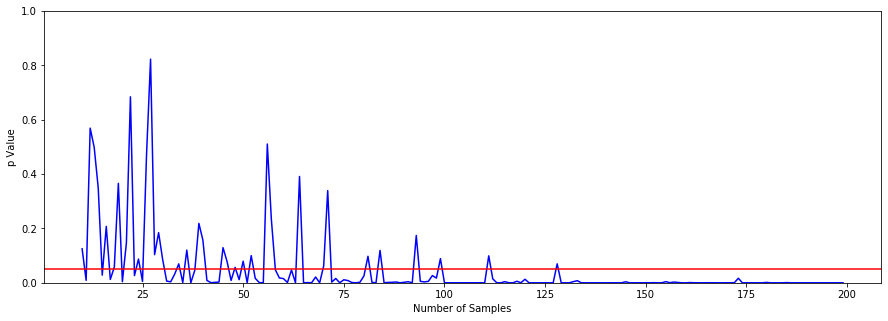

In [5]:
figsize(15, 5)
plt.plot(N, p_values, color="b")
plt.xlabel("Number of Samples")
plt.ylabel("p Value")
plt.axhline(0.05, color="r")
plt.ylim([0.0, 1.0])

### Conclusion:

1. The smaller the effect we are trying to measure, the more sample we have to have and hence the longer we have to run the A/B test. This is sometimes not feasible.

2. We still have a 5% error rate even if we have enough samples.

3. If we fail to reject H0, that does not tell us whether A is better than B or not, we just do not have enough evidence!

4. The t-test assumes that we are sampling randomly from two distinct populations/distributions. This assumption often
   does NOT apply. Example: Black Friday CTR are expected to be higher than other days.

5. To apply the t-test, both groups must have equal number of samples
   

## 3. Bayesian A/B test approaches using PyMC3

## 3.1 Estimating the CTR from user data

In [6]:
# we can use the click data directly from both groups to estimate CTR_A and CTR_B
# we can drop the assumption that we have equal number of impressions during the 30 days the test was running
N_impressions_A = 5000
N_impressions_B = 7500

# we are using a Bernoulli RV here with prob('user clicks the Ad') = prob('1') = CTR/100
p_A_true = CTR_A_true/100
p_B_true = CTR_B_true/100

data_user_A = stats.bernoulli.rvs(p_A_true, size=N_impressions_A)
data_user_B = stats.bernoulli.rvs(p_B_true, size=N_impressions_B)

print("observed CTR_A = ", np.sum(data_user_A)*100/N_impressions_A)
print("observed CTR_B = ", np.sum(data_user_B)*100/N_impressions_B)

observed CTR_A =  3.08
observed CTR_B =  3.6266666666666665


In [7]:
# since we know CTR or p is between 0 and 1 and we can assume we have no prior idea of the value, 
# we can use a uniform prior for both p_A and p_B

with pm.Model() as ab_test:
    p_A = pm.Uniform('p_A', lower=0, upper=1)
    p_B = pm.Uniform('p_B', lower=0, upper=1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_B - p_A)

    
    # what liklihood function does our data follow ? since we are modeling binary data we use again the Bernoulli RV
    obs_A = pm.Bernoulli("obs_A", p_A, observed=data_user_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=data_user_B)

    # sampling the posterior distributions
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step, return_inferencedata=False)
    usable_trace = trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 33 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [8]:
p_A_samples = usable_trace["p_A"]
p_B_samples = usable_trace["p_B"]
delta_samples = usable_trace["delta"]

In [9]:
len(p_A_samples)

76000

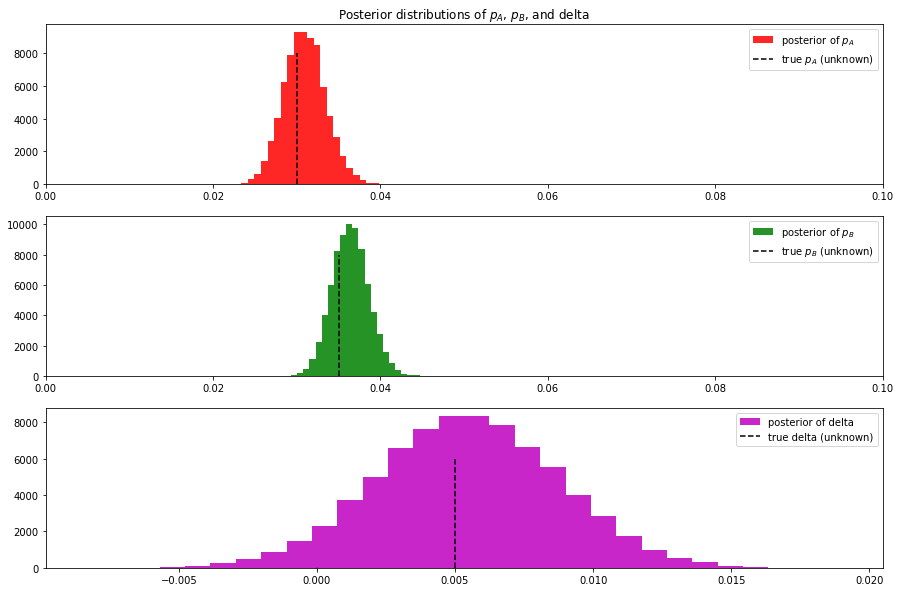

In [10]:
figsize(15, 10)
#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="r")
plt.vlines(p_A_true, 0, 8000, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85, label="posterior of $p_B$", color="g")
plt.vlines(p_B_true, 0, 8000, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85, label="posterior of delta", color="m")
plt.vlines(p_B_true - p_A_true, 0, 6000, linestyle="--", label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [11]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability Ad B is WORSE than Ad A = {}".format(np.mean(delta_samples < 0)))
    

print("Probability Ad B is BETTER than Ad A = {}".format(np.mean(delta_samples > 0)))
    

print("Estimated Improvement of CTR of Ad B over Ad A = {}".format(np.mean(delta_samples)*100))

Probability Ad B is WORSE than Ad A = 0.04881578947368421
Probability Ad B is BETTER than Ad A = 0.9511842105263157
Estimated Improvement of CTR of Ad B over Ad A = 0.5456042637028535


### Conclusion:

1. We were able to give a perscentage to the original yes/No question instead of a binary output to the hypothesis question

2. We do not need to assume anything about the data, we need only to choose an appropriate prior that reflects any
   informed guesses we have and an appropriate liklihood funtion that depends on the type of data we are collecting
   
3. Note that because we have less data on Ad A than on Ad B its posterior distribution is wider

## 3.2 Estimating the CTR from daily CTR data

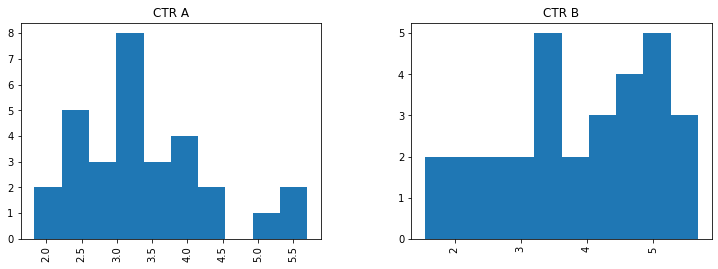

In [12]:
pooled_data = pd.DataFrame(
    dict(value=np.r_[data_A, data_B], group=np.r_[["CTR A"] * len(data_A), ["CTR B"] * len(data_B)])
)

pooled_data.hist("value", by="group", figsize=(12, 4));

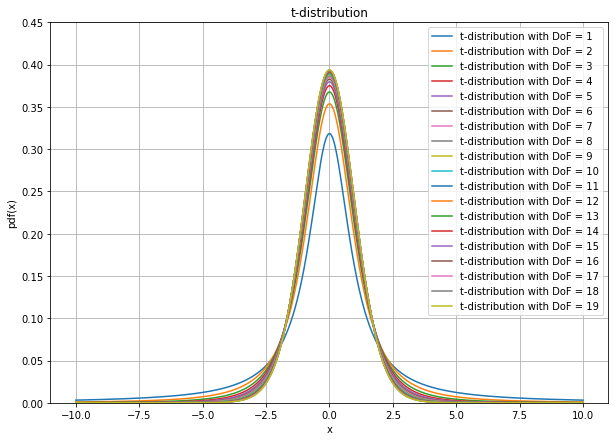

In [13]:
# since the data here is continous and has a somewhat uniform shape, we can go with a t-distribution liklihood
# t-distributions are more robust to outliers 
# t-distributions are defined by three parameters:  
# mean 𝜇, a precision (inverse-std) 𝜆 and a degrees-of-freedom parameter 𝜈
# the degrees-of-freedom parameter essentially specifies the “normality” of the data, 
# larger values of 𝜈 make the distribution converge to a normal distribution

fig, ax = plt.subplots(figsize=(10,7))
*dof, = np.arange(1,20)
xs = np.linspace(-10,10,1000)

# note here that in scipy the scale parameter is the std not the inverse
for df in dof:
    ax.plot(xs, stats.t.pdf(xs,loc=0, scale=1, df=df), label="t-distribution with DoF = {}".format(df))

ax.set_xlabel('x')
ax.set_ylabel('pdf(x)')
ax.set_title('t-distribution')
ax.legend(loc='best', frameon=True)
ax.set_ylim(0,0.45)
ax.grid(True)

In [14]:
# so for each group, we have three RVs: mean, std and df
# let assume the two groups/Ads have different means (our CTRs) and spreads (std) but the same df
# the means are RVs and a reasonable prior would be a normal distribution with mean and std equal the 
# pooled empirical corresponding values
 

pooled_mean = pooled_data.value.mean()
pooled_std = pooled_data.value.std() * 2

with pm.Model() as model:
    mean_A = pm.Normal("mean_A", mu=pooled_mean, sd=pooled_std)
    mean_B = pm.Normal("mean_B", mu=pooled_mean, sd=pooled_std)

In [15]:
# std is also a RV here. We dont know much about the true spread of both groups so we will use a uniform prior
# the limits of the uniform distribution can be guessed based on our knowledge of possible realistic values for CTR

std_low = 1
std_high = 5

with model:
    std_A = pm.Uniform("std_A", lower=std_low, upper=std_high)
    std_B = pm.Uniform("std_B", lower=std_low, upper=std_high)

In [16]:
# for the df, there is a higher probability that the data distribution is closer to a normal than a t-distribution
# with fat tails. Hence we use an exponential prior

with model:
    df = pm.Exponential("df_minus_one", 1 / 29.0) + 1

In [17]:
# defining our liklihood 

precision_A = std_A ** -2
precision_B = std_B ** -2

with model:
    liklihood_A = pm.StudentT("liklihood_A", nu=df, mu=mean_A, lam=precision_A, observed=data_A)
    liklihood_B = pm.StudentT("liklihood_B", nu=df, mu=mean_B, lam=precision_B, observed=data_B)
    delta_of_means = pm.Deterministic("delta_of_means", mean_B - mean_A)
    
    # sampling the posterior distributions
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step, return_inferencedata=False)
    usable_trace=trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [df_minus_one]
>Metropolis: [std_B]
>Metropolis: [std_A]
>Metropolis: [mean_B]
>Metropolis: [mean_A]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 46 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [18]:
mean_A_samples = usable_trace["mean_A"]
mean_B_samples = usable_trace["mean_B"]
delta_of_means_samples = usable_trace["delta_of_means"]

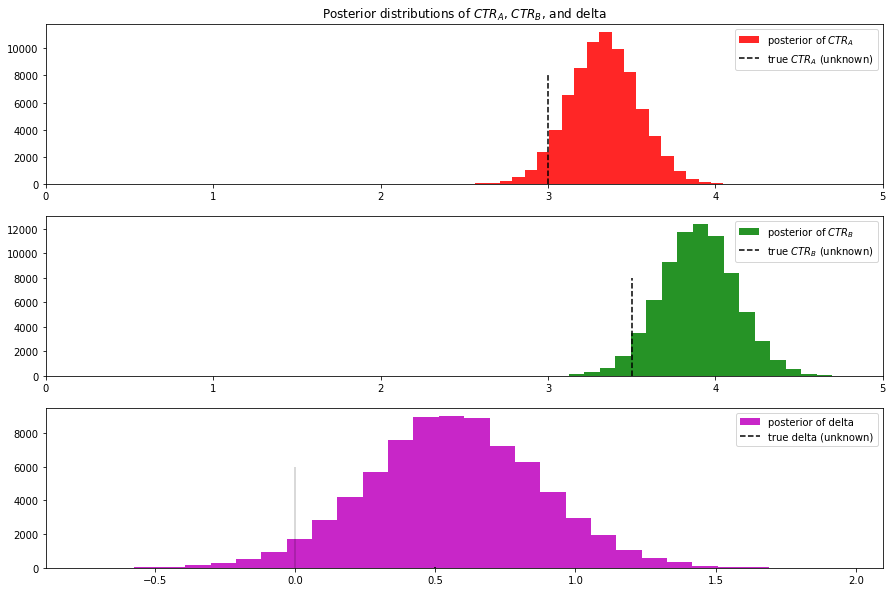

In [19]:

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, 5)
plt.hist(mean_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $CTR_A$", color="r")
plt.vlines(CTR_A_true, 0, 8000, linestyle="--", label="true $CTR_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $CTR_A$, $CTR_B$, and delta")

ax = plt.subplot(312)

plt.xlim(0, 5)
plt.hist(mean_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $CTR_B$", color="g")
plt.vlines(CTR_B_true, 0, 8000, linestyle="--", label="true $CTR_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_of_means_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="m")
plt.vlines(CTR_B_true - CTR_A_true, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 6000,  color="black", alpha=0.2)
plt.legend(loc="upper right");

In [20]:

print("Probability Ad B is WORSE than Ad A = {}".format(np.mean(delta_of_means_samples < 0)))
    

print("Probability Ad B is BETTER than Ad A = {}".format(np.mean(delta_of_means_samples > 0)))
    

print("Estimated Improvement of CTR of Ad B over Ad A = {}".format(np.mean(delta_of_means_samples)))

Probability Ad B is WORSE than Ad A = 0.03201315789473684
Probability Ad B is BETTER than Ad A = 0.9679868421052632
Estimated Improvement of CTR of Ad B over Ad A = 0.5647848332599078


### Conclusion:

1. I was able to interpret uncertainty in answering my question: is ad A better than ad B ?
2. I was able to estimate the difference between the CTR performance of both versions
3. Having the posterior distribution can also be used in calculating variance, confidence intervals ..etc.